In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import load_svmlight_file

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import MNIST data set

In [2]:
X, y = load_svmlight_file('usps.txt')
X = X.toarray()
y = y - 1

# Randomly sample 3000 samples from the dataset
# to reduce the size for faster processing
sample_indices = np.random.choice(len(X), size=3000, replace=False)
features_num = X[sample_indices]
labels_num = y[sample_indices]

print('='*20 + 'MNIST Dataset' + '='*20)
print('Number of samples: ', features_num.shape[0])
print('Number of features for each sample: ', features_num.shape[1])
print('Number of classes: ', len(set(labels_num)))
print(f"Pixel value range: [{features_num.min()}, {features_num.max()}]")

print('='*53)

print(f"Samples per class:\n")
samples_per_class = pd.Series(labels_num).value_counts().sort_index()
print(samples_per_class)

print('='*53)

class_counts = pd.Series(labels_num).value_counts().sort_index()
print(f"Class distribution (%):\n{(class_counts / len(labels_num) * 100).round(2)}")

====================MNIST Dataset====================
Number of samples:  3000
Number of features for each sample:  256
Number of classes:  10
Pixel value range: [-1.0, 0.999982]
Samples per class:

0.0    495
1.0    410
2.0    303
3.0    281
4.0    262
5.0    234
6.0    259
7.0    270
8.0    228
9.0    258
Name: count, dtype: int64
Class distribution (%):
0.0    16.50
1.0    13.67
2.0    10.10
3.0     9.37
4.0     8.73
5.0     7.80
6.0     8.63
7.0     9.00
8.0     7.60
9.0     8.60
Name: count, dtype: float64


#### Data analysis 

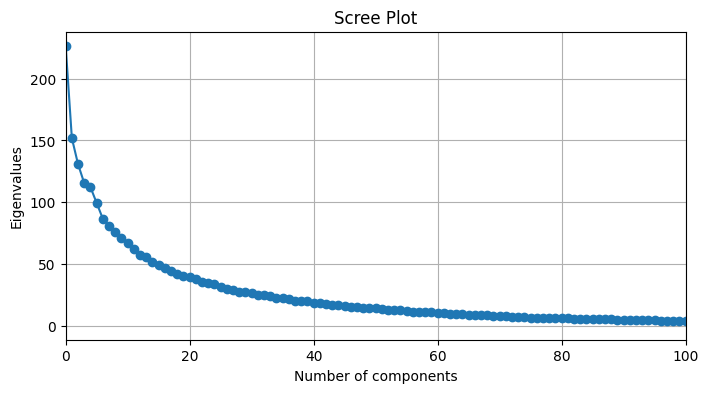

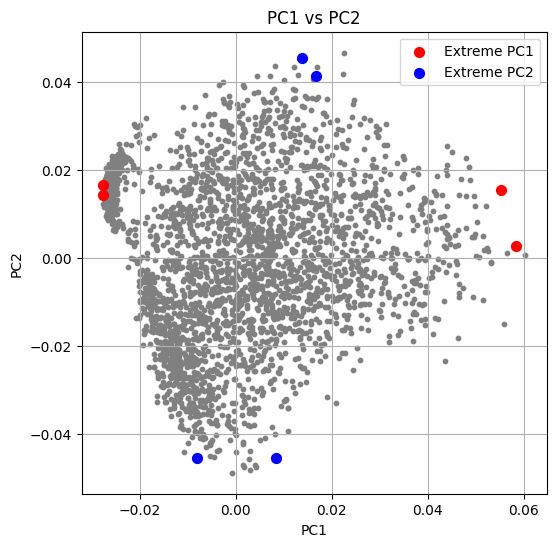

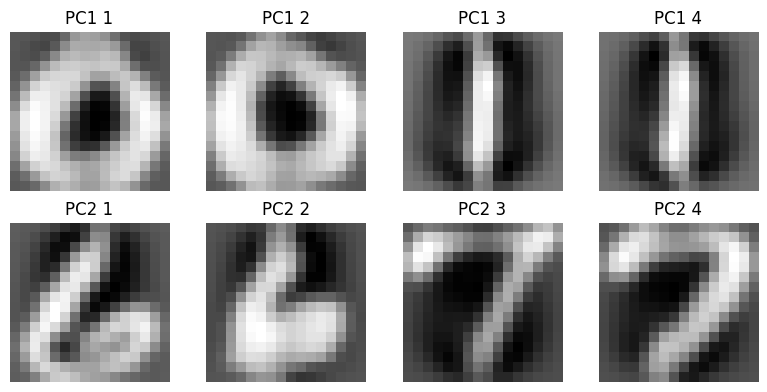

In [4]:
features_num_mean = features_num - features_num.mean(axis=0)


U, s, Vt = np.linalg.svd(features_num_mean, full_matrices=False)


plt.figure(figsize=(8, 4))
plt.plot(s, '-o')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.xlim(0, 100)
plt.title('Scree Plot')
plt.grid(True)
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(U[:, 0], U[:, 1], s=10, c='gray')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')


aa = np.argsort(-U[:, 0])  
bb = np.argsort(-U[:, 1])
au = list(np.random.choice(aa[:10], 2)) + list(np.random.choice(aa[-10:], 2))
bu = list(np.random.choice(bb[:10], 2)) + list(np.random.choice(bb[-10:], 2))

plt.scatter(U[au, 0], U[au, 1], c='red', s=50, label='Extreme PC1')
plt.scatter(U[bu, 0], U[bu, 1], c='blue', s=50, label='Extreme PC2')
plt.legend()
plt.grid(True)
plt.show()


def plot_digit(vec, title=''):
    img = vec.reshape(16, 16)
    plt.imshow(img, cmap='gray')  
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(8, 4))
for i in range(len(au)):
    plt.subplot(2, 4, i + 1)
    plot_digit(features_num_mean[au[i]], title=f'PC1 {i+1}')
for i in range(len(bu)):
    plt.subplot(2, 4, i + 5)
    plot_digit(features_num_mean[bu[i]], title=f'PC2 {i+1}')
plt.tight_layout()
plt.show()

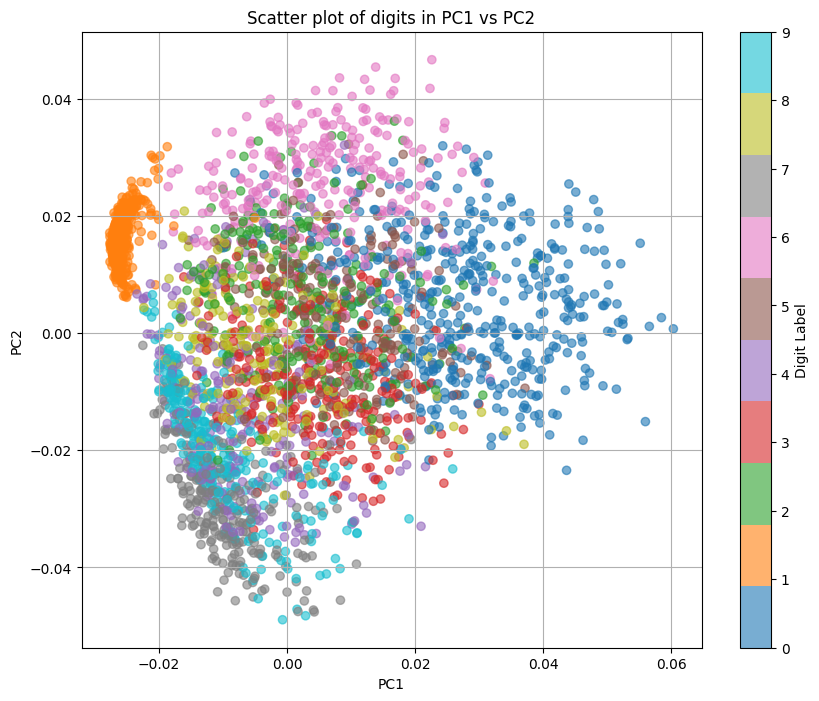

In [5]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(U[:, 0], U[:, 1], c=labels_num, cmap='tab10', alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter plot of digits in PC1 vs PC2")
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.grid(True)
plt.show()

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


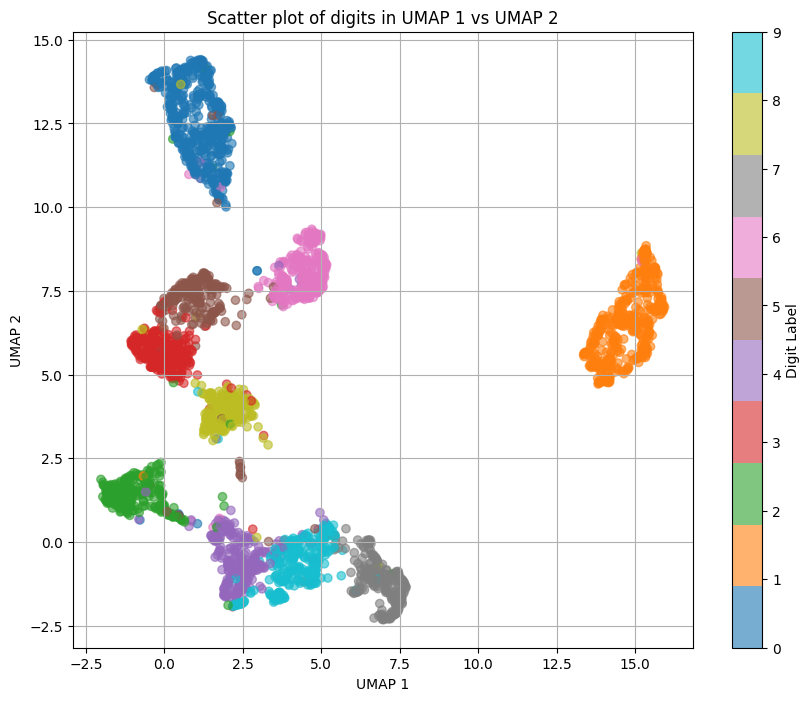

In [7]:
reducer_2d = umap.UMAP(n_components=2, random_state=42)
X_2d = reducer_2d.fit_transform(features_num_mean)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_num, cmap='tab10', alpha=0.6)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Scatter plot of digits in UMAP 1 vs UMAP 2")
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.grid(True)
plt.show()

### Import cats and dogs data set

In [2]:
features_cd = pd.read_csv('catdogdata.txt', sep=' ').values

labels_cd = np.zeros(features_cd.shape[0])
labels_cd[99:] = 1

print('='*15 + 'Cat vs Dog Dataset' + '='*15)
print('Number of samples: ', features_cd.shape[0])
print('Number of features for each sample: ', features_cd.shape[1])
print('Number of classes: ', len(np.unique(labels_cd)))
print(f"Pixel value range: [{features_cd.min()}, {features_cd.max()}]")

print('='*48)

print(f"Samples per class:\n{pd.Series(labels_cd).value_counts().sort_index()}")

print('='*48)

class_counts = pd.Series(labels_cd).value_counts().sort_index()

print(f"Class distribution (%):\n{(class_counts / len(labels_cd) * 100).round(2)}")

print('='*48)

===============Cat vs Dog Dataset===============
Number of samples:  198
Number of features for each sample:  4096
Number of classes:  2
Pixel value range: [0, 255]
Samples per class:
0.0    99
1.0    99
Name: count, dtype: int64
Class distribution (%):
0.0    50.0
1.0    50.0
Name: count, dtype: float64


#### Data analysis

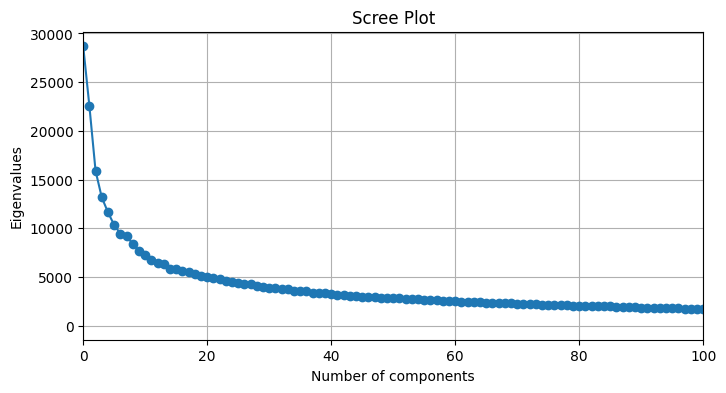

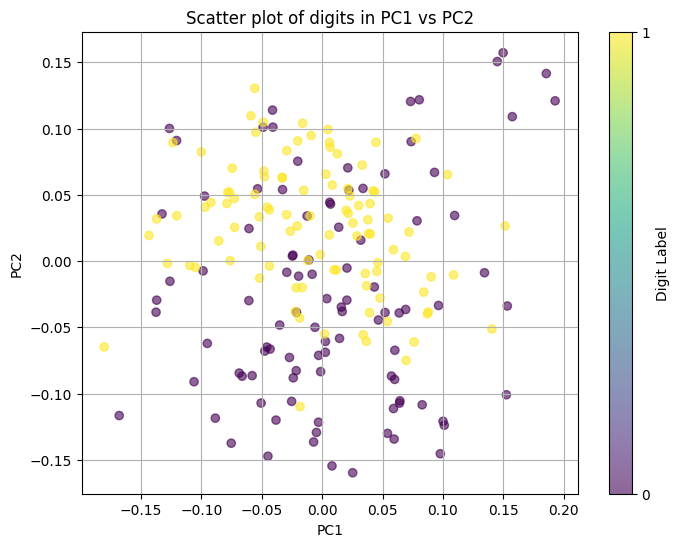

In [13]:
features_cd_mean = features_cd - features_cd.mean(axis=0)
U, s, Vt = np.linalg.svd(features_cd_mean, full_matrices=False)


plt.figure(figsize=(8, 4))
plt.plot(s, '-o')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.xlim(0, 100)
plt.title('Scree Plot')
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
scatter = plt.scatter(U[:, 0], U[:, 1], c=labels_cd, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter plot of digits in PC1 vs PC2")
plt.colorbar(scatter, ticks=range(2), label='Digit Label')
plt.grid(True)
plt.show()

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


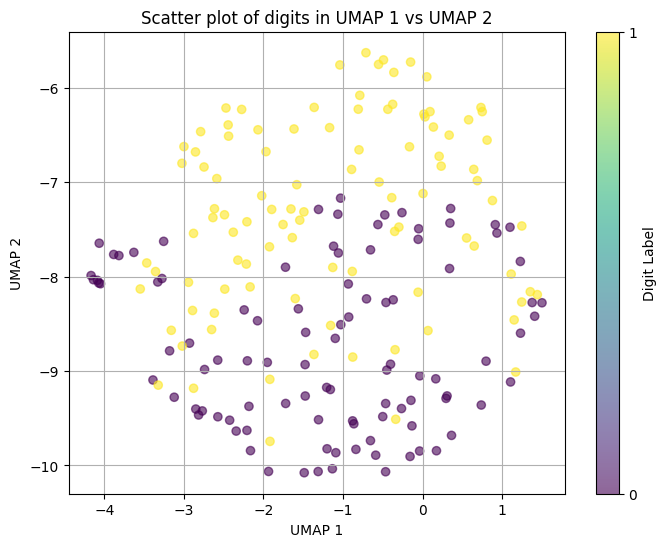

In [ ]:
reducer_2d = umap.UMAP(n_components=2, random_state=42, )
X_2d = reducer_2d.fit_transform(features_cd_mean)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_cd, alpha=0.6)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("Scatter plot of digits in UMAP 1 vs UMAP 2")
plt.colorbar(scatter, ticks=range(2), label='Digit Label')
plt.grid(True)
plt.show()

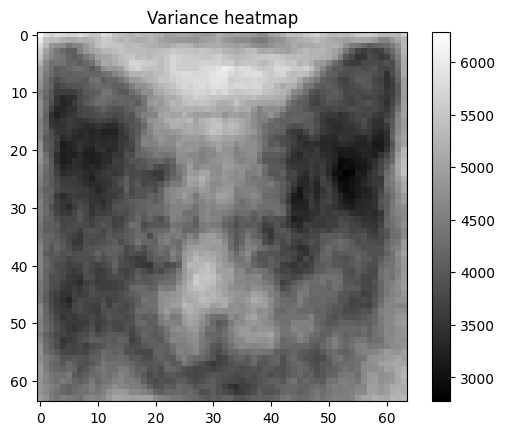

In [ ]:
def rotateM(img):
   return np.rot90(img, k=-1)

variances = np.var(features_cd_mean, axis=0)

maxv = np.argsort(variances)[::-1] 

# Variance heatmap
plt.imshow(rotateM(variances.reshape(64, 64)), cmap='gray')
plt.title("Variance heatmap")
plt.colorbar()
plt.show()

## Task 1

(A) Can clustering discover the classes in the data sets?

(B) Are the well-defined clusters in the data sets?

Use at least 3 different clustering techniques and at least 2 methods to pick the number of clusters.

You should compare both the cluster results between the methods (B) and against the true classes (A).

Make sure to explain how you picked the features to use (e.g. low-dimensional representations (linear/nonlinear), feature filtering (e.g. variance, Hartigan's diptest (tests lack of unimodality of features).

For B, you should also adress the stability of the clustering via e.g. resampling or other perturbations.

### Method 1: PCA/variance + k-means + Silhouette

#### MNIST dataset

In [21]:
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(features_num)
scaled_num = scaled_num - scaled_num.mean(axis=0)

reducer = umap.UMAP(n_components=3, random_state=42)
X_3d = reducer.fit_transform(scaled_num)

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
def double_CV(X, y, k_range):

    # Outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    sil_score = []
    best_k_list = []
    
    for i, (train_idx, _) in enumerate(outer_cv.split(X, y)):

        print(f"Outer Fold {i + 1}")
        # Split the data into training and testing sets
        X_train_outer = X[train_idx]
        y_train_outer = y[train_idx]

        best_k = None
        best_silhouette = -1
        k_scores = []
        
        # Perform inner cross-validation for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    

        # Preprocessing pipeline
        pipeline = Pipeline([
            ('minmax', MinMaxScaler()),
            ('center', StandardScaler(with_std=False)),
            ('reducer', umap.UMAP(n_components=10, random_state=42))
        ])

        for p in k_range:
            fold_scores = []
            for train_idx_inner, val_idx_inner in inner_cv.split(X_train_outer, y_train_outer):
                X_train_inner = pipeline.fit_transform(X_train_outer[train_idx_inner])
                y_train_inner = y_train_outer[train_idx_inner] 

                kmeans = KMeans(n_clusters=p, n_init=10, random_state=42)
                labels = kmeans.fit_predict(X_train_inner)
                score = silhouette_score(X_train_inner, labels)
                fold_scores.append(score)

            mean_score = np.mean(fold_scores)
            k_scores.append(mean_score)

            if mean_score > best_silhouette:
                best_silhouette = mean_score
                best_k = p

        # Plot the silhouette scores for different k and n values
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, k_scores, marker='o')
        plt.title(f"Inner CV Silhouette Scores - Outer Fold {i + 1}")
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.xticks(k_range)
        plt.grid(True)
        plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k: {best_k}')
        plt.legend()
        plt.show()
        
        
        X_train_outer = pipeline.fit_transform(X_train_outer)
        best_kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
        best_labels = best_kmeans.fit_predict(X_train_outer)
        best_k_list.append(best_k)

        
        # Calculate silhouette score for the outer training set
        silhouette = silhouette_score(X_train_outer, best_labels)
        sil_score.append(silhouette)
        print(f"Best k: {best_k} with silhouette score: {silhouette:.4f}")

        sample_sil_values = silhouette_samples(X_train_outer, best_labels)
        # Create silhouette plot
        plt.figure(figsize=(6, 4))
        y_lower = 10
        for cluster in range(best_k):
            ith_cluster_silhouette_values = sample_sil_values[best_labels == cluster]
            ith_cluster_silhouette_values.sort()

            size_cluster = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster

            color = plt.cm.nipy_spectral(float(cluster) / best_k)
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0, ith_cluster_silhouette_values,
                facecolor=color, edgecolor=color, alpha=0.7
            )

            plt.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
            y_lower = y_upper + 10  # Space between clusters

        plt.title(f'Silhouette Plot - Outer Fold {i + 1} (k={best_k})')
        plt.xlabel("Silhouette Coefficient Values")
        plt.ylabel("Cluster Label")
        plt.yticks([])
        plt.axvline(x=silhouette, color="red", linestyle="--")
        plt.tight_layout()
        plt.show()

        # Creat a comparison table
        comparison_table = pd.crosstab(y_train_outer, best_labels,
                                rownames=['True Label'], colnames=['Cluster Label'])
        print(comparison_table)

        # Calculate the adjusted Rand index
        ari = adjusted_rand_score(y_train_outer, best_labels)
        print(f"Adjusted Rand Index: {ari:.4f}")

    mean_sil= np.mean(sil_score)
    std_sil = np.std(sil_score)
    print(f"Mean Silhouette Score: {mean_sil:.4f} ± {std_sil:.4f}")
    print(f"Best k values across outer folds: {best_k_list}")
    mean_best_k = np.mean(best_k_list)
    print(f"Mean best k value across outer folds: {mean_best_k:.2f}")

    return mean_sil, std_sil

Outer Fold 1


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarn

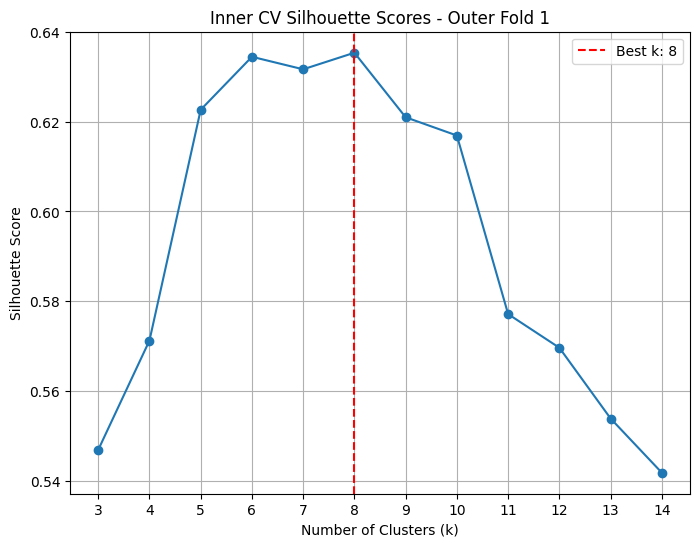

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best k: 8 with silhouette score: 0.6535


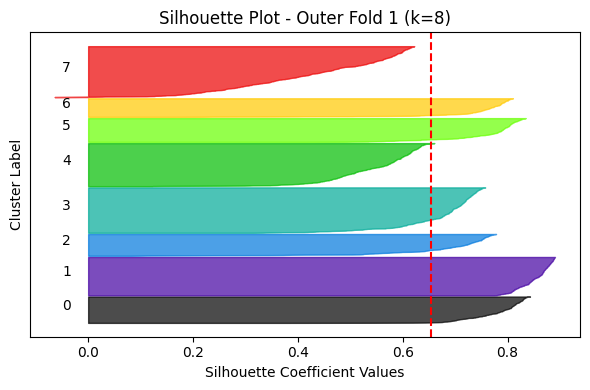

Cluster Label    0    1    2    3    4    5    6    7
True Label                                           
0.0              2    0    0  386    0    3    0    1
1.0              0  341    0    0    0    1    0    0
2.0              2    0    3    4    2  203    3    3
3.0              0    0    0    1  220    1    3    3
4.0              4    0    0    1    0    2    0  197
5.0              4    0    0    7  157    3    1    8
6.0            223    1    0    5    0    0    0    1
7.0              0    0  188    0    0    0    1    8
8.0              1    1    1    2    6    0  158    6
9.0              0    0    3    0    0    0    1  228
Adjusted Rand Index: 0.7883
Outer Fold 2


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarn

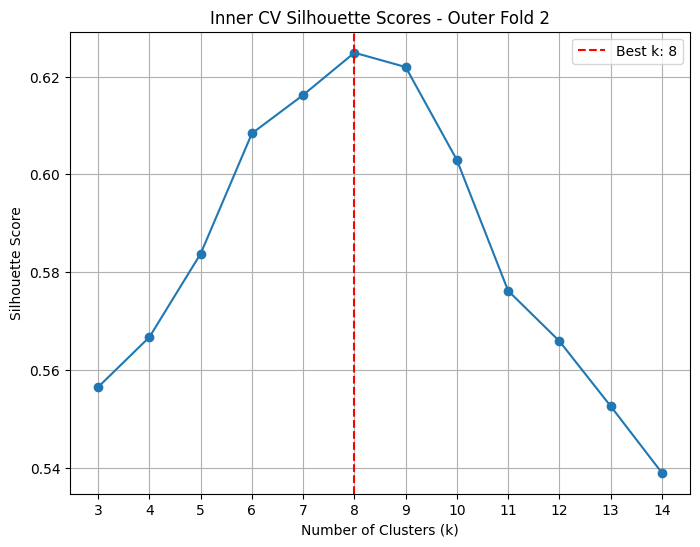

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best k: 8 with silhouette score: 0.6453


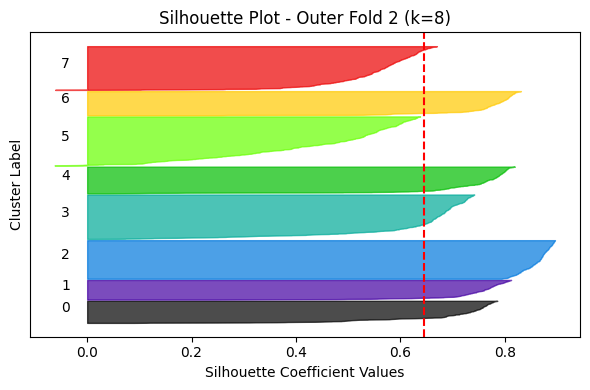

Cluster Label    0    1    2    3    4    5    6    7
True Label                                           
0.0              0    0    0  384    5    0    2    0
1.0              0    0  342    0    0    0    0    0
2.0              2    5    0    3    0    1  207    1
3.0              0    5    0    0    0    1    0  223
4.0              0    0    1    0    5  196    3    0
5.0              0    1    0    5    5    9    3  157
6.0              0    0    1    3  224    1    1    1
7.0            188    2    0    0    0    6    0    0
8.0              1  161    1    2    0    1    0    9
9.0              7    2    0    0    0  223    0    0
Adjusted Rand Index: 0.7963
Outer Fold 3


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarn

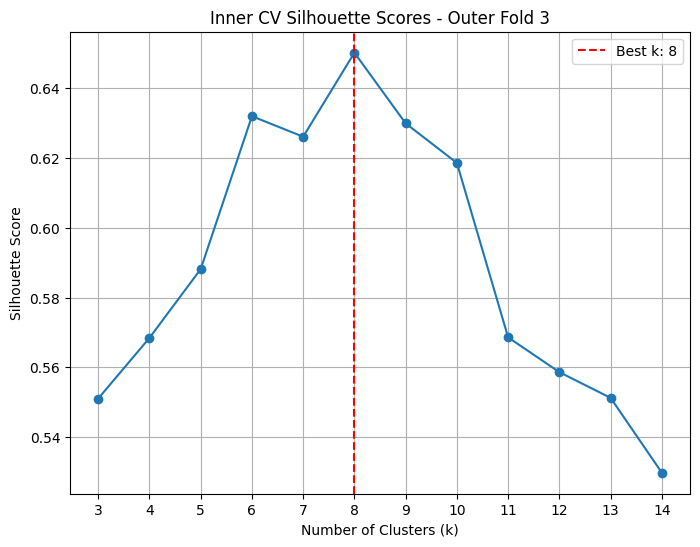

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best k: 8 with silhouette score: 0.6673


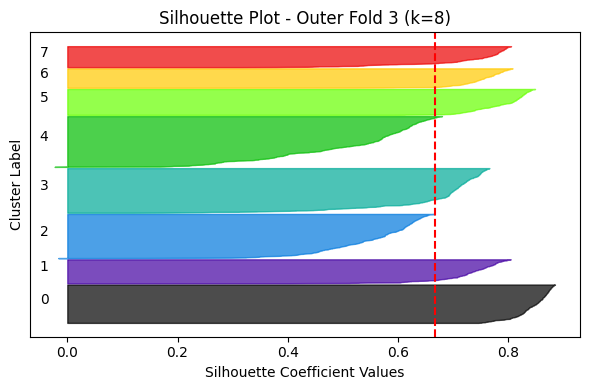

Cluster Label    0    1    2    3    4    5    6    7
True Label                                           
0.0              0    2    0  389    0    0    0    0
1.0            341    1    0    0    0    0    0    0
2.0              0  204    1    2    3    1    6    2
3.0              0    1  221    0    2    1    4    0
4.0              0    2    0    1  199    3    0    0
5.0              0    4  164    4    5    2    1    0
6.0              2    1    0    3    1  224    0    0
7.0              0    0    0    0   12    0    1  184
8.0              0    0    9    0    3    1  161    0
9.0              0    0    0    0  229    0    1    2
Adjusted Rand Index: 0.7990
Outer Fold 4


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarn

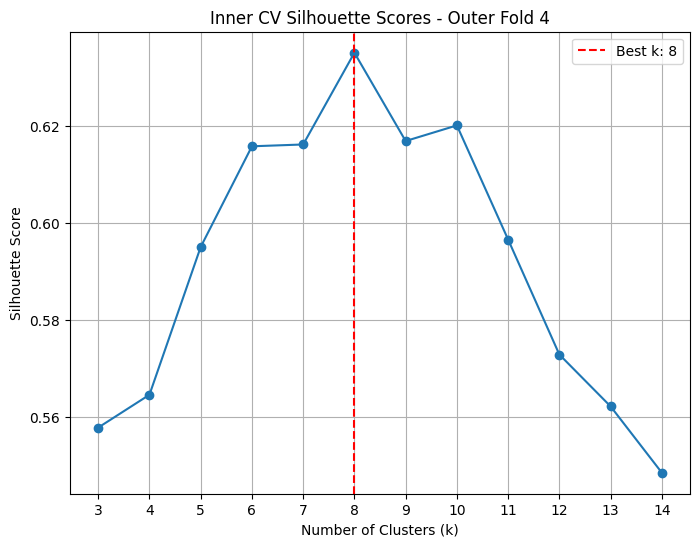

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best k: 8 with silhouette score: 0.6344


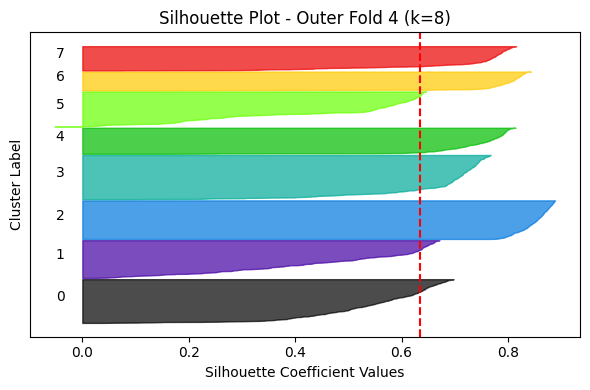

Cluster Label    0    1    2    3    4    5    6    7
True Label                                           
0.0              0    1    0  383    3    0    0    4
1.0              0    0  342    0    0    0    0    1
2.0              0    5    0    5    1    2    1  205
3.0            223    2    0    0    0    0    3    1
4.0              0  195    0    1    5    3    0    1
5.0            159    9    0    2    5    2    1    2
6.0              2    3    2    3  219    0    0    1
7.0              0    1    0    0    0  196    0    0
8.0              7    0    1    1    0    2  161    2
9.0              0  122    0    0    0  109    1    0
Adjusted Rand Index: 0.7749
Outer Fold 5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarn

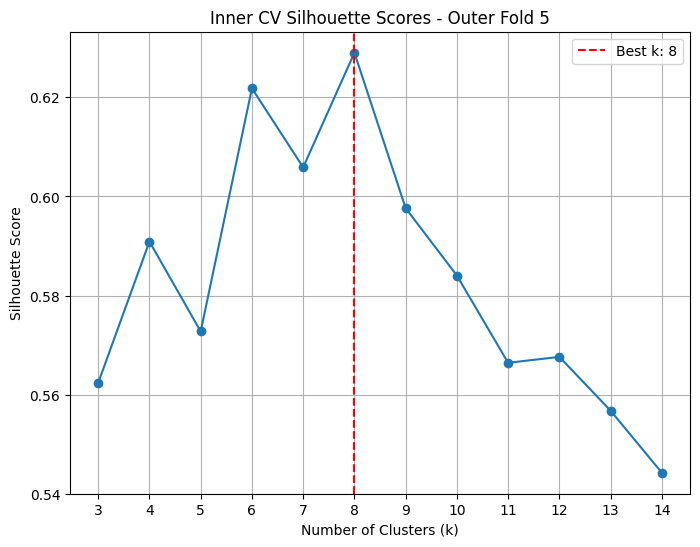

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best k: 8 with silhouette score: 0.6475


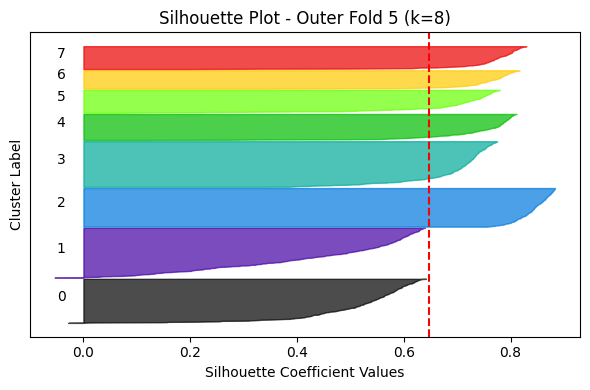

Cluster Label    0    1    2    3    4    5    6    7
True Label                                           
0.0              0    0    0  387    3    0    0    1
1.0              0    0  342    0    0    0    0    1
2.0              1    4    0    6    1    3    3  201
3.0            220    2    0    0    0    0    6    1
4.0              0  201    0    2    1    0    0    1
5.0            161    3    0    6    9    0    1    0
6.0              1    2    2    6  219    0    0    0
7.0              0    5    0    0    0  192    0    0
8.0             11    4    1    1    0    2  155    0
9.0              0  224    0    0    0    8    0    0
Adjusted Rand Index: 0.7896
Mean Silhouette Score: 0.6496 ± 0.0108
Best k values across outer folds: [8, 8, 8, 8, 8]
Mean best k value across outer folds: 8.00


In [21]:
k_range = range(3, 15)

mean_sil, std_sil = double_CV(features_num, labels_num, k_range)

#### Cats n Dogs

In [65]:
def double_CV_cd(X, y, k_range):

    # Outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    sil_score = []
    best_k_list = []
    
    for i, (train_idx, _) in enumerate(outer_cv.split(X, y)):

        print(f"Outer Fold {i + 1}")
        # Split the data into training and testing sets
        X_train_outer = X[train_idx]
        y_train_outer = y[train_idx]

        best_k = None
        best_silhouette = -1
        k_scores = []
        
        # Perform inner cross-validation for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    

        # Preprocessing pipeline
        pipeline = Pipeline([
            ('minmax', MinMaxScaler()),
            ('center', StandardScaler(with_std=False)),
        ])

        for p in k_range:
            fold_scores = []
            for train_idx_inner, val_idx_inner in inner_cv.split(X_train_outer, y_train_outer):
                X_train_inner = pipeline.fit_transform(X_train_outer[train_idx_inner])
                y_train_inner = y_train_outer[train_idx_inner]

                n_select = 15
                variances = np.var(X_train_inner, axis=0)
                indices = np.argsort(variances)[::-1][:n_select]
                X_train_inner = X_train_inner[:, indices]

                kmeans = KMeans(n_clusters=p, n_init=10, random_state=42)
                labels = kmeans.fit_predict(X_train_inner)
                score = silhouette_score(X_train_inner, labels)
                fold_scores.append(score)

            mean_score = np.mean(fold_scores)
            k_scores.append(mean_score)

            if mean_score > best_silhouette:
                best_silhouette = mean_score
                best_k = p

        # Plot the silhouette scores for different k and n values
        plt.figure(figsize=(8, 6))
        plt.plot(k_range, k_scores, marker='o')
        plt.title(f"Inner CV Silhouette Scores - Outer Fold {i + 1}")
        plt.xlabel("Number of Clusters (k)")
        plt.ylabel("Silhouette Score")
        plt.xticks(k_range)
        plt.grid(True)
        plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k: {best_k}')
        plt.legend()
        plt.show()
        
        
        X_train_outer = pipeline.fit_transform(X_train_outer)
        n_select = 15
        variances = np.var(X_train_outer, axis=0)
        indices = np.argsort(variances)[::-1][:n_select]
        X_train_outer = X_train_outer[:, indices]
        print(f"Selected features shape: {X_train_outer.shape}")

        #Plot the selected features with original features
        plt.figure(figsize=(10, 8))
        plt.scatter(X_train_outer[:, 0], X_train_outer[:, 1], c=y_train_outer, cmap='tab10', alpha=0.6)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Scatter plot of selected features")
        plt.colorbar(scatter, ticks=range(10), label='Digit Label')
        plt.grid(True)
        plt.show()

        best_kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
        best_labels = best_kmeans.fit_predict(X_train_outer)
        best_k_list.append(best_k)

        
        # Calculate silhouette score for the outer training set
        silhouette = silhouette_score(X_train_outer, best_labels)
        sil_score.append(silhouette)
        print(f"Best k: {best_k} with silhouette score: {silhouette:.4f}")

        sample_sil_values = silhouette_samples(X_train_outer, best_labels)
        # Create silhouette plot
        plt.figure(figsize=(6, 4))
        y_lower = 10
        for cluster in range(best_k):
            ith_cluster_silhouette_values = sample_sil_values[best_labels == cluster]
            ith_cluster_silhouette_values.sort()

            size_cluster = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster

            color = plt.cm.nipy_spectral(float(cluster) / best_k)
            plt.fill_betweenx(
                np.arange(y_lower, y_upper),
                0, ith_cluster_silhouette_values,
                facecolor=color, edgecolor=color, alpha=0.7
            )

            plt.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
            y_lower = y_upper + 10  # Space between clusters

        plt.title(f'Silhouette Plot - Outer Fold {i + 1} (k={best_k})')
        plt.xlabel("Silhouette Coefficient Values")
        plt.ylabel("Cluster Label")
        plt.yticks([])
        plt.axvline(x=silhouette, color="red", linestyle="--")
        plt.tight_layout()
        plt.show()

        # Creat a comparison table
        comparison_table = pd.crosstab(y_train_outer, best_labels,
                                rownames=['True Label'], colnames=['Cluster Label'])
        print(comparison_table)

        # Calculate the adjusted Rand index
        ari = adjusted_rand_score(y_train_outer, best_labels)
        print(f"Adjusted Rand Index: {ari:.4f}")

    mean_sil= np.mean(sil_score)
    std_sil = np.std(sil_score)
    print(f"Mean Silhouette Score: {mean_sil:.4f} ± {std_sil:.4f}")
    print(f"Best k values across outer folds: {best_k_list}")
    mean_best_k = np.mean(best_k_list)
    print(f"Mean best k value across outer folds: {mean_best_k:.2f}")

    return mean_sil, std_sil

Selected features: 5
Silhouette Score: 0.4967
Selected features: 10
Silhouette Score: 0.5160
Selected features: 15
Silhouette Score: 0.5233
Selected features: 20
Silhouette Score: 0.5195
Selected features: 25
Silhouette Score: 0.4992
Selected features: 30
Silhouette Score: 0.5090
Selected features: 35
Silhouette Score: 0.5146
Selected features: 40
Silhouette Score: 0.5033
Selected features: 45
Silhouette Score: 0.5089


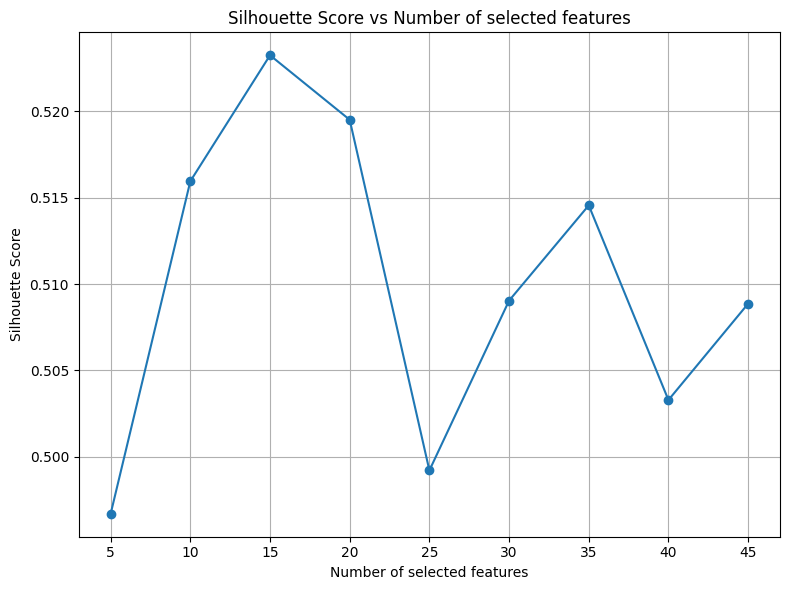

In [67]:
selected_num = np.arange(5, 50, 5)
sil_scores = []

for i in selected_num:
    print(f"Selected features: {i}")

    scaler = MinMaxScaler()
    scaled_cd = scaler.fit_transform(features_cd)

    variances = np.var(scaled_cd, axis=0)
    indices = np.argsort(variances)[::-1][:i]
    selected_features = scaled_cd[:, indices]

    kmeans = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans.fit_predict(selected_features)

    # Calculate silhouette score
    silhouette = silhouette_score(selected_features, cluster_labels)
    print(f"Silhouette Score: {silhouette:.4f}")

    sil_scores.append(silhouette)

# Plot the silhouette scores for different k values
plt.figure(figsize=(8, 6))
plt.plot(selected_num, sil_scores, marker='o')
plt.title("Silhouette Score vs Number of selected features")
plt.xlabel("Number of selected features")
plt.ylabel("Silhouette Score")
plt.xticks(selected_num)
plt.grid()
plt.tight_layout()
plt.show()

Outer Fold 1


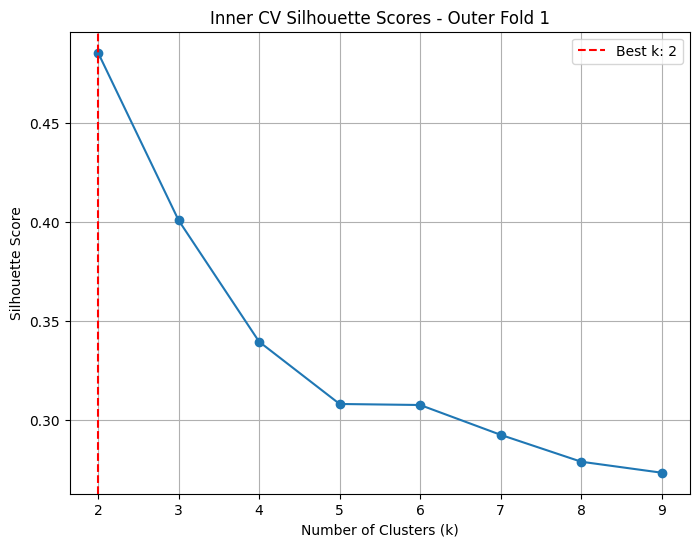

Selected features shape: (158, 15)


/tmp/ipykernel_81901/2113927359.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 3 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ticks=range(10), label='Digit Label')


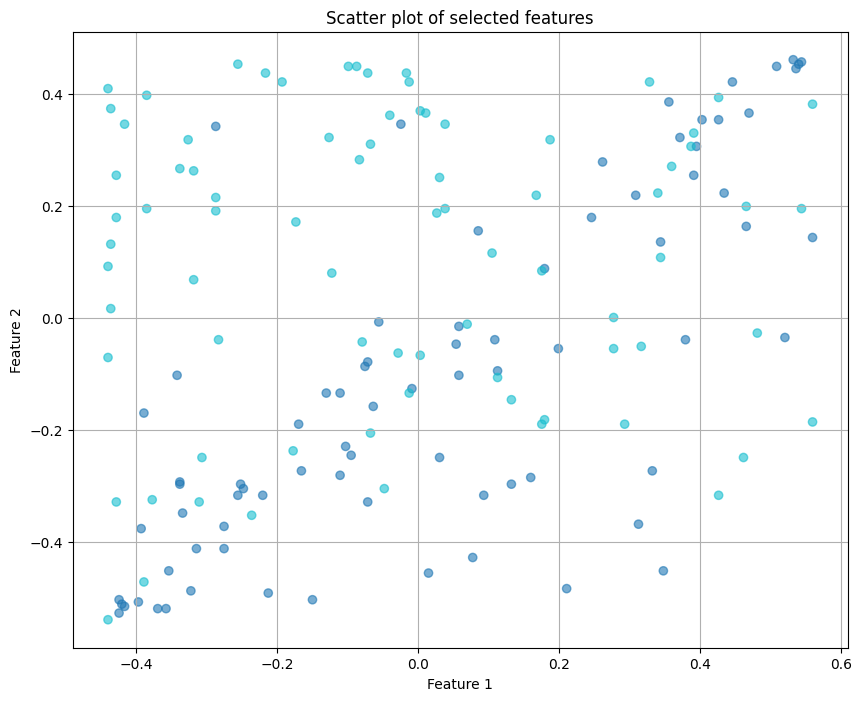

Best k: 2 with silhouette score: 0.5264


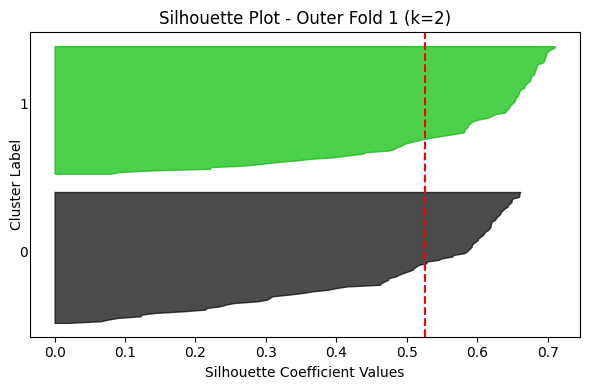

Cluster Label   0   1
True Label           
0.0            54  25
1.0            26  53
Adjusted Rand Index: 0.1200
Outer Fold 2


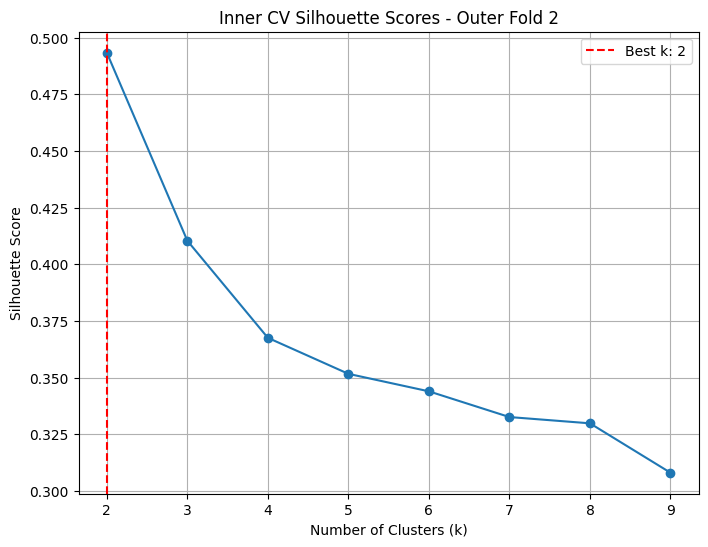

Selected features shape: (158, 15)


/tmp/ipykernel_81901/2113927359.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 4 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ticks=range(10), label='Digit Label')


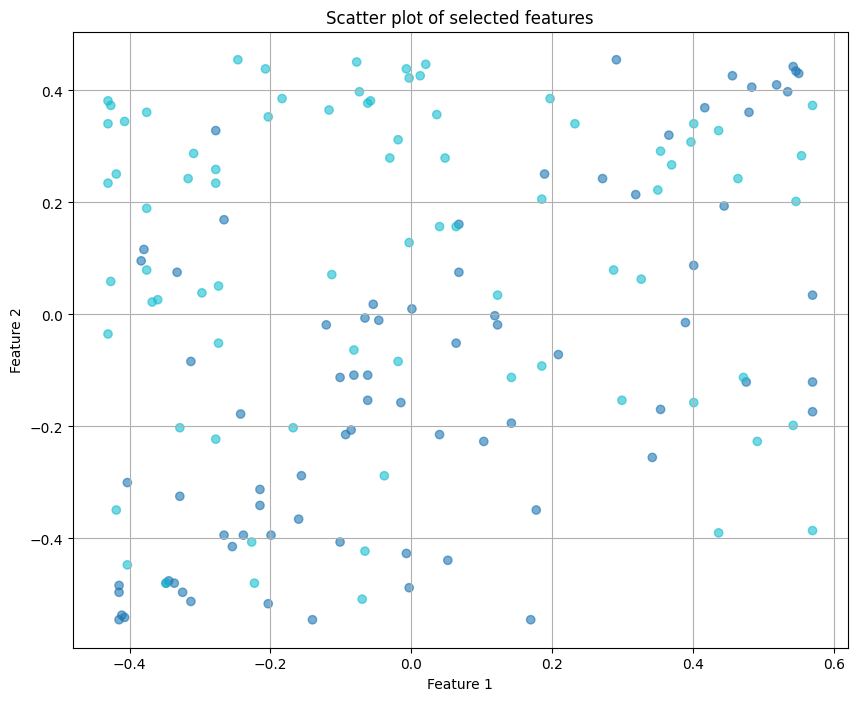

Best k: 2 with silhouette score: 0.5200


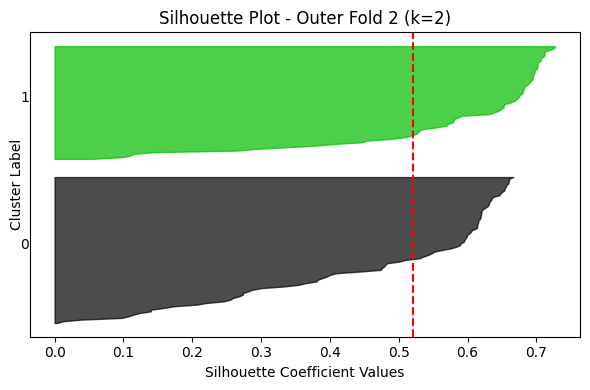

Cluster Label   0   1
True Label           
0.0            58  21
1.0            31  48
Adjusted Rand Index: 0.1112
Outer Fold 3


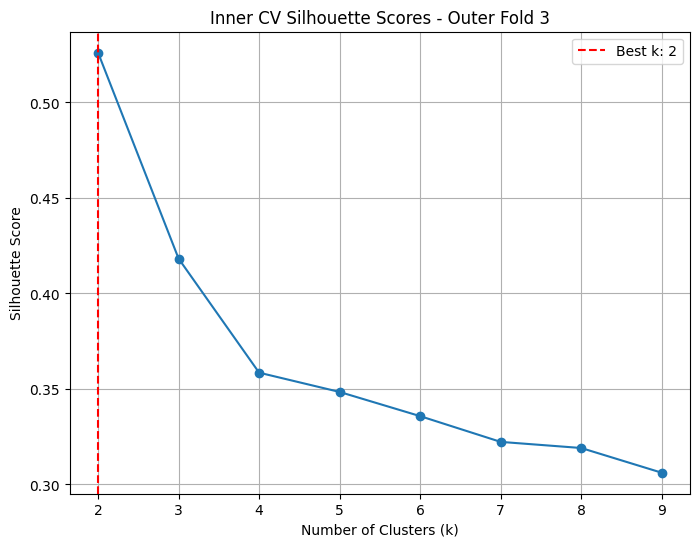

Selected features shape: (158, 15)


/tmp/ipykernel_81901/2113927359.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 5 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ticks=range(10), label='Digit Label')


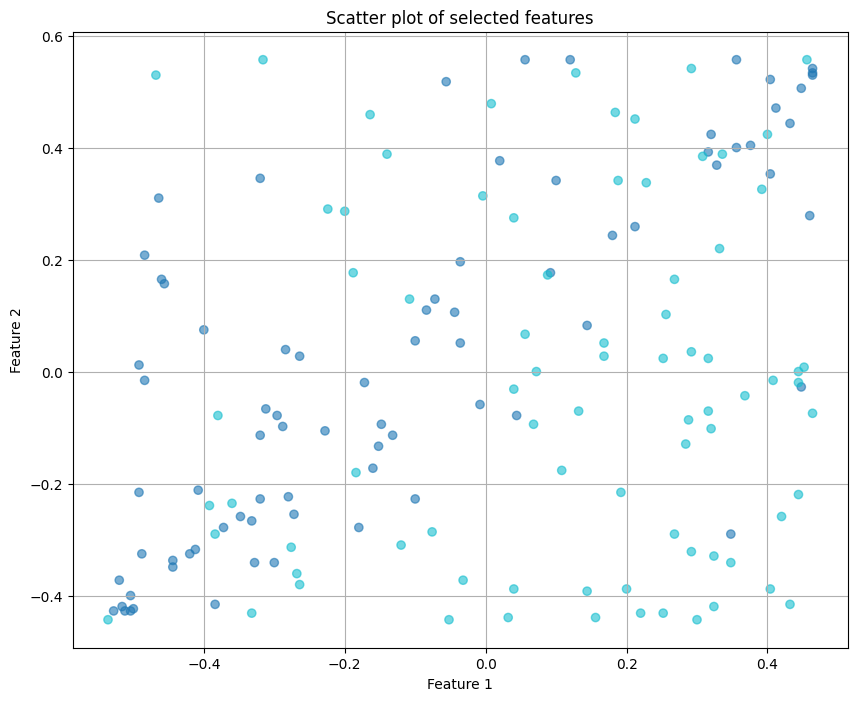

Best k: 2 with silhouette score: 0.5425


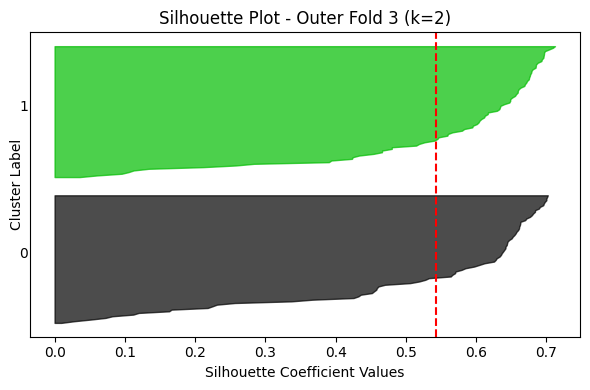

Cluster Label   0   1
True Label           
0.0            55  24
1.0            23  56
Adjusted Rand Index: 0.1587
Outer Fold 4


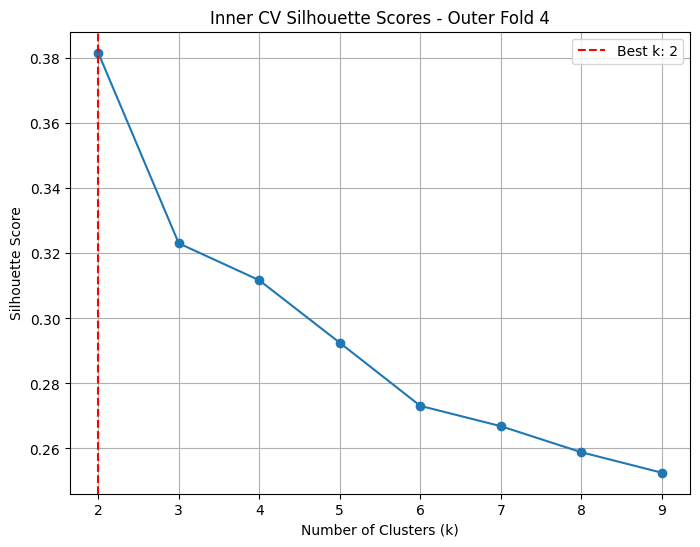

Selected features shape: (159, 15)


/tmp/ipykernel_81901/2113927359.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 6 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ticks=range(10), label='Digit Label')


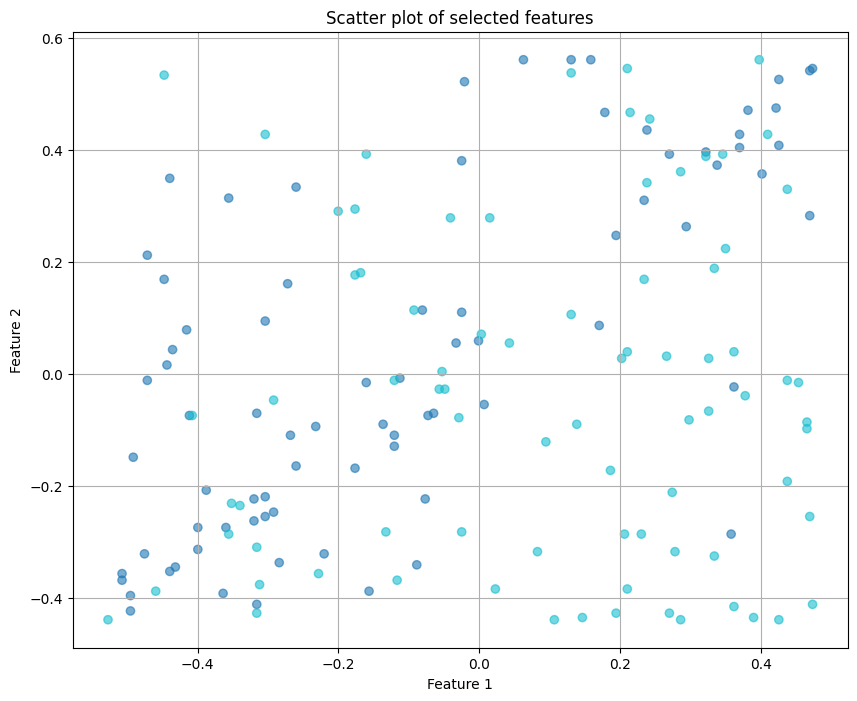

Best k: 2 with silhouette score: 0.3819


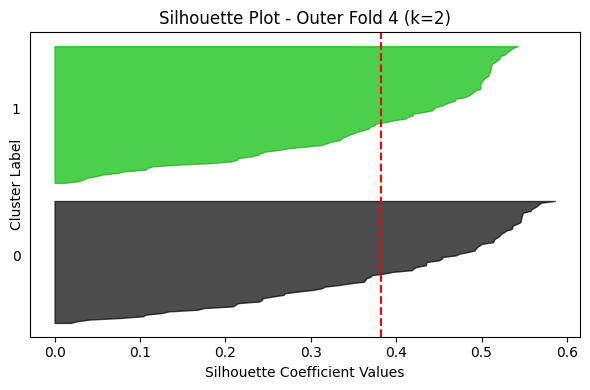

Cluster Label   0   1
True Label           
0.0            52  27
1.0            23  57
Adjusted Rand Index: 0.1322
Outer Fold 5


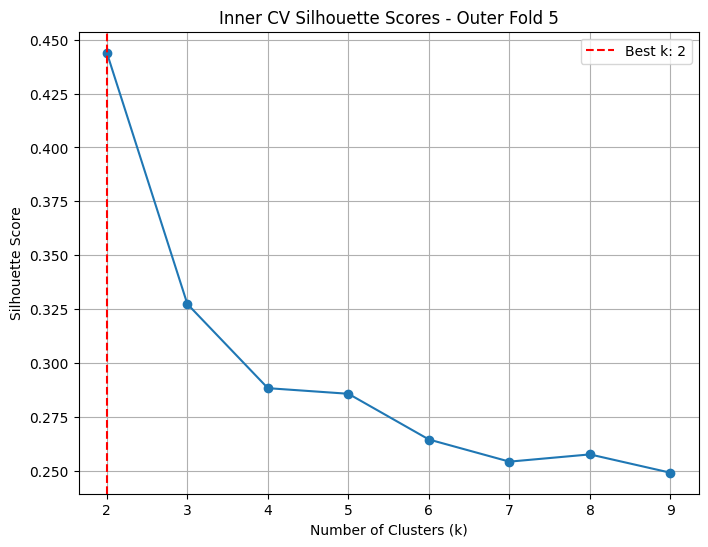

Selected features shape: (159, 15)


/tmp/ipykernel_81901/2113927359.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 7 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, ticks=range(10), label='Digit Label')


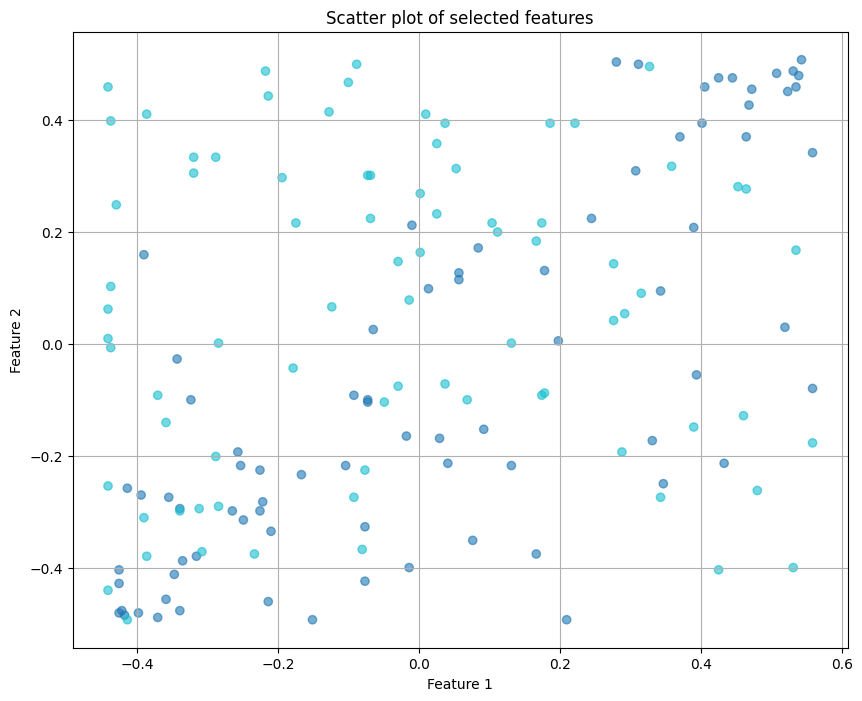

Best k: 2 with silhouette score: 0.4982


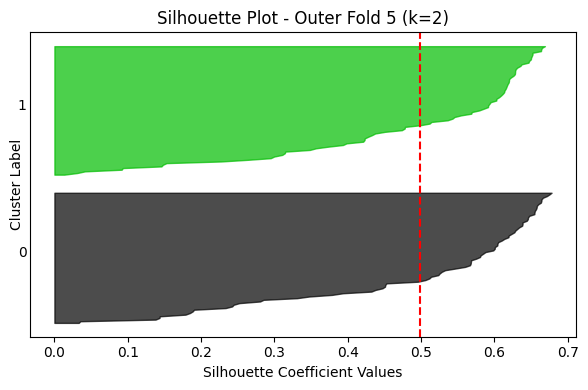

Cluster Label   0   1
True Label           
0.0            28  52
1.0            52  27
Adjusted Rand Index: 0.0892
Mean Silhouette Score: 0.4938 ± 0.0577
Best k values across outer folds: [2, 2, 2, 2, 2]
Mean best k value across outer folds: 2.00


In [66]:
k_range = range(2, 10)

mean_sil_cd, std_sil_cd = double_CV_cd(features_cd, labels_cd, k_range)

### Method 2: DBSCAN

#### MINST dataset

In [39]:
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(features_num)
scaled_num = scaled_num - scaled_num.mean(axis=0)

reducer = umap.UMAP(n_components=10, random_state=42)
features_UMAP_num = reducer.fit_transform(scaled_num)

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


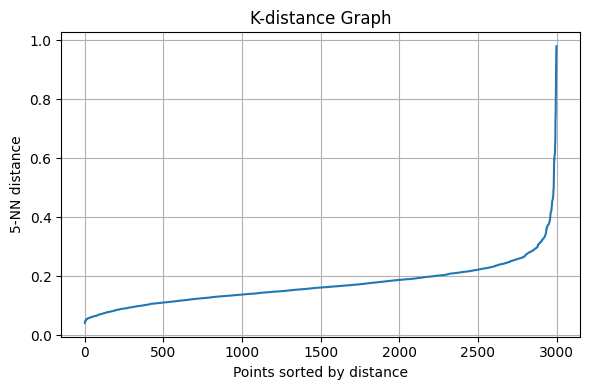

In [ ]:

min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(features_UMAP_num)
distances, indices = neighbors_fit.kneighbors(features_UMAP_num)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
run_times = 5
best_eps_list = []
best_min_samples_list = []
sil_list = []

for i in range(run_times):
    max_score = 0
    print(f"Run {i + 1}/{run_times}")
    # Randomly sample 2400 samples from the dataset
    sample_indices = np.random.choice(len(features_num), size=2400, replace=False)
    features_num_run = features_num[sample_indices]
    labels_num_run = labels_num[sample_indices]

    # Scale the features
    scaler = MinMaxScaler()
    scaled_num = scaler.fit_transform(features_num_run)
    scaled_num = scaled_num - scaled_num.mean(axis=0)

    # Apply UMAP
    reducer = umap.UMAP(n_components=10, random_state=42)
    features_UMAP_num = reducer.fit_transform(scaled_num)

    for eps in np.arange(0.25, 0.5, 0.01):
        for min_samples in np.arange(2, 35):
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(features_UMAP_num)
            if len(set(labels)) <= 1:
                continue
            score = silhouette_score(features_UMAP_num, labels)
            if score > max_score:
                max_score = score
                best_eps = eps
                best_min_samples = min_samples
            print(f"eps={eps}, min_samples={min_samples}, clusters={len(set(labels)) - (1 if -1 in labels else 0)}")
            print(f"Silhouette score: {score:.4f}")
            print("="*20)

    print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Max silhouette score: {max_score:.4f}")
    best_eps_list.append(best_eps)
    best_min_samples_list.append(best_min_samples)
    sil_list.append(max_score)
    print("="*50)

print(f"Best eps values across runs: {best_eps_list}")
print(f"Best min_samples values across runs: {best_min_samples_list}")
mean_sil = np.mean(sil_list)
std_sil = np.std(sil_list)
print(f"Mean Silhouette Score: {mean_sil:.4f} ± {std_sil:.4f}")
print(f"Best eps: {np.mean(best_eps_list):.4f} ± {np.std(best_eps_list):.4f}")
print(f"Best min_samples: {np.mean(best_min_samples_list):.4f} ± {np.std(best_min_samples_list):.4f}")



Run 1/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


eps=0.25, min_samples=2, clusters=28
Silhouette score: -0.1518
eps=0.25, min_samples=3, clusters=19
Silhouette score: -0.0187
eps=0.25, min_samples=4, clusters=17
Silhouette score: 0.0882
eps=0.25, min_samples=5, clusters=19
Silhouette score: 0.0354
eps=0.25, min_samples=6, clusters=25
Silhouette score: 0.0670
eps=0.25, min_samples=7, clusters=34
Silhouette score: 0.1080
eps=0.25, min_samples=8, clusters=39
Silhouette score: 0.0865
eps=0.25, min_samples=9, clusters=43
Silhouette score: 0.0819
eps=0.25, min_samples=10, clusters=47
Silhouette score: 0.1224
eps=0.25, min_samples=11, clusters=53
Silhouette score: 0.1151
eps=0.25, min_samples=12, clusters=55
Silhouette score: 0.0425
eps=0.25, min_samples=13, clusters=52
Silhouette score: -0.0381
eps=0.25, min_samples=14, clusters=45
Silhouette score: -0.1227
eps=0.25, min_samples=15, clusters=41
Silhouette score: -0.1948
eps=0.25, min_samples=16, clusters=34
Silhouette score: -0.2702
eps=0.25, min_samples=17, clusters=29
Silhouette score: -

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


eps=0.25, min_samples=2, clusters=34
Silhouette score: 0.2152
eps=0.25, min_samples=3, clusters=25
Silhouette score: 0.3196
eps=0.25, min_samples=4, clusters=26
Silhouette score: 0.3257
eps=0.25, min_samples=5, clusters=24
Silhouette score: 0.3480
eps=0.25, min_samples=6, clusters=25
Silhouette score: 0.3502
eps=0.25, min_samples=7, clusters=34
Silhouette score: 0.1270
eps=0.25, min_samples=8, clusters=34
Silhouette score: 0.1507
eps=0.25, min_samples=9, clusters=43
Silhouette score: 0.1646
eps=0.25, min_samples=10, clusters=47
Silhouette score: 0.1536
eps=0.25, min_samples=11, clusters=50
Silhouette score: 0.0936
eps=0.25, min_samples=12, clusters=52
Silhouette score: 0.0355
eps=0.25, min_samples=13, clusters=51
Silhouette score: -0.0019
eps=0.25, min_samples=14, clusters=46
Silhouette score: -0.0819
eps=0.25, min_samples=15, clusters=43
Silhouette score: -0.1662
eps=0.25, min_samples=16, clusters=38
Silhouette score: -0.2335
eps=0.25, min_samples=17, clusters=33
Silhouette score: -0.

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


eps=0.25, min_samples=2, clusters=21
Silhouette score: 0.2641
eps=0.25, min_samples=3, clusters=18
Silhouette score: 0.2869
eps=0.25, min_samples=4, clusters=15
Silhouette score: 0.3334
eps=0.25, min_samples=5, clusters=18
Silhouette score: 0.3683
eps=0.25, min_samples=6, clusters=17
Silhouette score: 0.3525
eps=0.25, min_samples=7, clusters=26
Silhouette score: 0.1982
eps=0.25, min_samples=8, clusters=34
Silhouette score: 0.2071
eps=0.25, min_samples=9, clusters=43
Silhouette score: 0.1291
eps=0.25, min_samples=10, clusters=44
Silhouette score: 0.1824
eps=0.25, min_samples=11, clusters=48
Silhouette score: 0.1045
eps=0.25, min_samples=12, clusters=50
Silhouette score: 0.0672
eps=0.25, min_samples=13, clusters=42
Silhouette score: -0.0287
eps=0.25, min_samples=14, clusters=40
Silhouette score: -0.1115
eps=0.25, min_samples=15, clusters=37
Silhouette score: -0.1644
eps=0.25, min_samples=16, clusters=33
Silhouette score: -0.2406
eps=0.25, min_samples=17, clusters=33
Silhouette score: -0.

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


eps=0.25, min_samples=2, clusters=34
Silhouette score: -0.0416
eps=0.25, min_samples=3, clusters=24
Silhouette score: 0.0450
eps=0.25, min_samples=4, clusters=26
Silhouette score: 0.1826
eps=0.25, min_samples=5, clusters=23
Silhouette score: 0.3071
eps=0.25, min_samples=6, clusters=25
Silhouette score: 0.3285
eps=0.25, min_samples=7, clusters=29
Silhouette score: 0.2926
eps=0.25, min_samples=8, clusters=38
Silhouette score: 0.2388
eps=0.25, min_samples=9, clusters=47
Silhouette score: 0.2092
eps=0.25, min_samples=10, clusters=48
Silhouette score: 0.1533
eps=0.25, min_samples=11, clusters=48
Silhouette score: 0.1529
eps=0.25, min_samples=12, clusters=55
Silhouette score: 0.1335
eps=0.25, min_samples=13, clusters=54
Silhouette score: 0.0362
eps=0.25, min_samples=14, clusters=47
Silhouette score: -0.0258
eps=0.25, min_samples=15, clusters=39
Silhouette score: -0.1171
eps=0.25, min_samples=16, clusters=39
Silhouette score: -0.1985
eps=0.25, min_samples=17, clusters=35
Silhouette score: -0.

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


eps=0.25, min_samples=2, clusters=33
Silhouette score: 0.2314
eps=0.25, min_samples=3, clusters=24
Silhouette score: 0.2944
eps=0.25, min_samples=4, clusters=22
Silhouette score: 0.2483
eps=0.25, min_samples=5, clusters=22
Silhouette score: 0.3309
eps=0.25, min_samples=6, clusters=23
Silhouette score: 0.2338
eps=0.25, min_samples=7, clusters=28
Silhouette score: 0.1436
eps=0.25, min_samples=8, clusters=32
Silhouette score: 0.0957
eps=0.25, min_samples=9, clusters=37
Silhouette score: 0.1352
eps=0.25, min_samples=10, clusters=43
Silhouette score: 0.1144
eps=0.25, min_samples=11, clusters=45
Silhouette score: 0.1292
eps=0.25, min_samples=12, clusters=50
Silhouette score: 0.0815
eps=0.25, min_samples=13, clusters=50
Silhouette score: 0.0188
eps=0.25, min_samples=14, clusters=47
Silhouette score: -0.0387
eps=0.25, min_samples=15, clusters=44
Silhouette score: -0.1267
eps=0.25, min_samples=16, clusters=40
Silhouette score: -0.2140
eps=0.25, min_samples=17, clusters=29
Silhouette score: -0.3

In [99]:
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(features_num)
scaled_num = scaled_num - scaled_num.mean(axis=0)

reducer = umap.UMAP(n_components=10, random_state=42)
features_UMAP_num = reducer.fit_transform(scaled_num)

db = DBSCAN(eps=best_eps, min_samples=24)
labels = db.fit_predict(features_UMAP_num)

comparison_table = pd.crosstab(labels_num, labels,
                        rownames=['True Label'], colnames=['Cluster Label'])
print(comparison_table)

# Calculate the adjusted Rand index
ari = adjusted_rand_score(labels_num, labels)
print(f"Adjusted Rand Index: {ari:.4f}")

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster Label    0    1    2    3
True Label                       
0.0            386    8    4    0
1.0              0    0    0  305
2.0              0  248    1    0
3.0              0  214    0    1
4.0              1  206    1    2
5.0              4  178    1    0
6.0              4    3  215    0
7.0              0  212    0    1
8.0              3  201    1    1
9.0              0  198    0    1
Adjusted Rand Index: 0.2599


#### Cats n Dogs

In [4]:
scaler = MinMaxScaler()
scaled_cd = scaler.fit_transform(features_cd)

n_select = 15
variances = np.var(scaled_cd, axis=0)
indices = np.argsort(variances)[::-1][:n_select]
selected_cd = scaled_cd[:, indices]

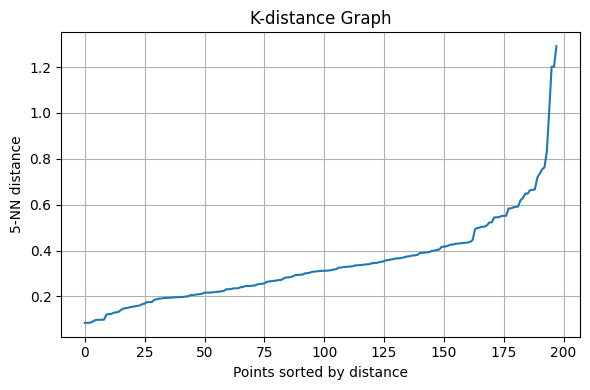

In [7]:
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(selected_cd)
distances, indices = neighbors_fit.kneighbors(selected_cd)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:

run_times = 5
best_eps_list = []
best_min_samples_list = []
sil_list = []

for i in range(run_times):
    max_score = 0
    print(f"Run {i + 1}/{run_times}")
    # Randomly sample 160 samples from the dataset
    sample_indices = np.random.choice(len(features_cd), size=160, replace=False)
    features_cd_run = features_cd[sample_indices]
    labels_cd_run = labels_cd[sample_indices]

    # Scale the features
    scaler = MinMaxScaler()
    scaled_cd = scaler.fit_transform(features_cd_run)
    scaled_cd = scaled_cd - scaled_cd.mean(axis=0)

    n_select = 15
    variances = np.var(scaled_cd, axis=0)
    indices = np.argsort(variances)[::-1][:n_select]
    selected_cd = scaled_cd[:, indices]


    for eps in np.arange(0.3, 0.8, 0.05):
        for min_samples in np.arange(2, 35):
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(selected_cd)
            if len(set(labels)) <= 1:
                continue
            score = silhouette_score(selected_cd, labels)
            if score > max_score:
                max_score = score
                best_eps = eps
                best_min_samples = min_samples
            print(f"eps={eps}, min_samples={min_samples}, clusters={len(set(labels)) + (1 if -1 in labels else 0)}")
            print(f"Silhouette score: {score:.4f}")
            print("="*20)

    print(f"Best eps: {best_eps}, Best min_samples: {best_min_samples}, Max silhouette score: {max_score:.4f}")
    best_eps_list.append(best_eps)
    best_min_samples_list.append(best_min_samples)
    sil_list.append(max_score)
    print("="*50)

print(f"Best eps values across runs: {best_eps_list}")
print(f"Best min_samples values across runs: {best_min_samples_list}")
mean_sil = np.mean(sil_list)
std_sil = np.std(sil_list)
print(f"Mean Silhouette Score: {mean_sil:.4f} ± {std_sil:.4f}")
print(f"Best eps: {np.mean(best_eps_list):.4f} ± {np.std(best_eps_list):.4f}")
print(f"Best min_samples: {np.mean(best_min_samples_list):.4f} ± {np.std(best_min_samples_list):.4f}")



Run 1/5
eps=0.3, min_samples=2, clusters=7
Silhouette score: 0.0323
eps=0.3, min_samples=3, clusters=6
Silhouette score: 0.0838
eps=0.3, min_samples=4, clusters=6
Silhouette score: 0.0880
eps=0.3, min_samples=5, clusters=6
Silhouette score: 0.0454
eps=0.3, min_samples=6, clusters=7
Silhouette score: -0.0313
eps=0.3, min_samples=7, clusters=5
Silhouette score: 0.1599
eps=0.3, min_samples=8, clusters=5
Silhouette score: 0.1599
eps=0.3, min_samples=9, clusters=4
Silhouette score: 0.1470
eps=0.3, min_samples=10, clusters=4
Silhouette score: 0.1388
eps=0.3, min_samples=11, clusters=4
Silhouette score: 0.1388
eps=0.3, min_samples=12, clusters=4
Silhouette score: 0.1316
eps=0.3, min_samples=13, clusters=4
Silhouette score: 0.0704
eps=0.3, min_samples=14, clusters=3
Silhouette score: 0.2357
eps=0.3, min_samples=15, clusters=3
Silhouette score: 0.2357
eps=0.3, min_samples=16, clusters=3
Silhouette score: 0.1879


eps=0.35, min_samples=2, clusters=8
Silhouette score: 0.0632
eps=0.35, min_samples=3, clusters=5
Silhouette score: 0.1612
eps=0.35, min_samples=4, clusters=5
Silhouette score: 0.1673
eps=0.35, min_samples=5, clusters=5
Silhouette score: 0.1670
eps=0.35, min_samples=6, clusters=6
Silhouette score: 0.1148
eps=0.35, min_samples=7, clusters=5
Silhouette score: 0.1832
eps=0.35, min_samples=8, clusters=5
Silhouette score: 0.1713
eps=0.35, min_samples=9, clusters=5
Silhouette score: 0.1845
eps=0.35, min_samples=10, clusters=5
Silhouette score: 0.0425
eps=0.35, min_samples=11, clusters=5
Silhouette score: 0.0425
eps=0.35, min_samples=12, clusters=4
Silhouette score: 0.1812
eps=0.35, min_samples=13, clusters=4
Silhouette score: 0.1492
eps=0.35, min_samples=14, clusters=5
Silhouette score: 0.0599
eps=0.35, min_samples=15, clusters=5
Silhouette score: 0.0565
eps=0.35, min_samples=16, clusters=5
Silhouette score: 0.0565
eps=0.35, min_samples=17, clusters=3
Silhouette score: 0.2357
eps=0.35, min_sa

In [11]:
scaler = MinMaxScaler()
scaled_cd = scaler.fit_transform(features_cd)

n_select = 15
variances = np.var(scaled_cd, axis=0)
indices = np.argsort(variances)[::-1][:n_select]
selected_cd = scaled_cd[:, indices]

db = DBSCAN(eps=0.56, min_samples=29)
labels = db.fit_predict(selected_cd)

comparison_table = pd.crosstab(labels_cd, labels,
                        rownames=['True Label'], colnames=['Cluster Label'])
print(comparison_table)

# Calculate the adjusted Rand index
ari = adjusted_rand_score(labels_cd, labels)
print(f"Adjusted Rand Index: {ari:.4f}")


Cluster Label  -1   0   1
True Label               
0.0            13  63  23
1.0            10  37  52
Adjusted Rand Index: 0.0723


### Method 3: GMM

#### MNIST

In [ ]:
run_times = 5

bic_scores = []

for i in range(run_times):
    print(f"Run {i + 1}/{run_times}")
    # Randomly sample 160 samples from the dataset
    sample_indices = np.random.choice(len(features_num), size=2400, replace=False)
    features_num_run = features_num[sample_indices]
    labels_num_run = labels_num[sample_indices]

    scaler = MinMaxScaler()
    scaled_num = scaler.fit_transform(features_num_run)
    scaled_num = scaled_num - scaled_num.mean(axis=0)

    reducer = umap.UMAP(n_components=10, random_state=42)
    X_umap = reducer.fit_transform(scaled_num)

    n_components_range = range(2, 20)

    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X_umap)
        labels = gmm.predict(X_umap)
        bic_scores.append(gmm.bic(X_umap))


Run 1/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Run 2/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Run 3/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Run 4/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Run 5/5


/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AttributeError: module 'numpy' has no attribute 'len'

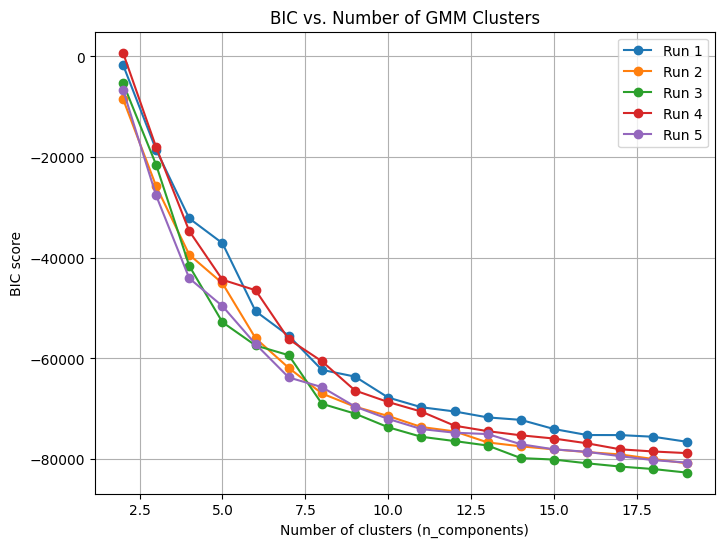

In [7]:

# Plot the BIC scores
bic_scores = np.array(bic_scores).reshape(run_times, len(n_components_range))

plt.figure(figsize=(8, 6))
for i in range(run_times):
    plt.plot(n_components_range, bic_scores[i], marker='o', label=f'Run {i + 1}')
plt.legend()
plt.xlabel('Number of clusters (n_components)')
plt.ylabel('BIC score')
plt.title('BIC vs. Number of GMM Clusters')
plt.grid(True)
plt.show()

In [12]:
scaler = MinMaxScaler()
scaled_num = scaler.fit_transform(features_num)
scaled_num = scaled_num - scaled_num.mean(axis=0)

reducer = umap.UMAP(n_components=10, random_state=42)
X_umap = reducer.fit_transform(scaled_num)

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_umap)
best_labels = gmm.predict(X_umap)

# Creat a comparison table
comparison_table = pd.crosstab(labels_num, best_labels,
                        rownames=['True Label'], colnames=['Cluster Label'])
print(comparison_table)

# Calculate the adjusted Rand index
ari = adjusted_rand_score(labels_num, best_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kay42/MPCAS/MVE441/Assignment_3/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Cluster Label    0    1    2    3    4    5    6    7    8    9
True Label                                                     
0.0            487    0    1    1    0    0    2    2    2    0
1.0              0  408    0    0    0    1    0    1    0    0
2.0              3    0    3    0    2    0    1  291    0    3
3.0              1    0    2  262    9    1    0    1    5    0
4.0              0    2    0    0    0   31    0    1    0  228
5.0              3    0    0    2    4    0    2    2  220    1
6.0              1    2    0    0    1    0  253    0    1    1
7.0              0    2  258    0    1    8    0    0    0    1
8.0              1    4    1    8  206    3    0    1    2    2
9.0              0    0    6    0    0  228    0    0    0   24
Adjusted Rand Index: 0.9035


#### Cats n Dogs

In [ ]:
features_cd

In [4]:
run_times = 5

bic_scores = []

for i in range(run_times):
    print(f"Run {i + 1}/{run_times}")
    # Randomly sample 160 samples from the dataset
    sample_indices = np.random.choice(len(features_cd), size=160, replace=False)
    features_cd_run = features_cd[sample_indices]
    labels_cd_run = labels_cd[sample_indices]

    scaler = MinMaxScaler()
    scaled_cd = scaler.fit_transform(features_cd_run)
    scaled_cd = scaled_cd - scaled_cd.mean(axis=0)

    n_select = 15
    variances = np.var(scaled_cd, axis=0)
    indices = np.argsort(variances)[::-1][:n_select]
    selected_cd = scaled_cd[:, indices]
    print(f"Selected features shape: {selected_cd.shape}")

    n_components_range = range(2, 15)

    for n in n_components_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(selected_cd)
        labels = gmm.predict(selected_cd)
        bic_scores.append(gmm.bic(selected_cd))

Run 1/5
Selected features shape: (160, 15)
Run 2/5
Selected features shape: (160, 15)
Run 3/5
Selected features shape: (160, 15)
Run 4/5
Selected features shape: (160, 15)
Run 5/5
Selected features shape: (160, 15)


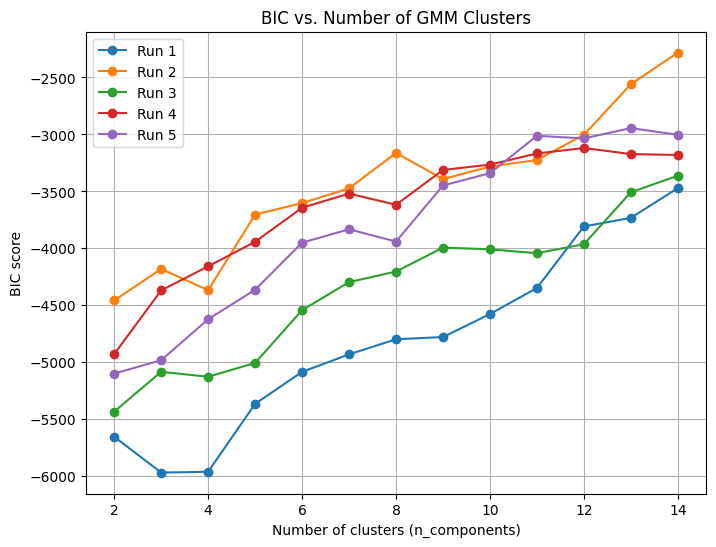

In [5]:
# Plot the BIC scores
bic_scores = np.array(bic_scores).reshape(run_times, len(n_components_range))

plt.figure(figsize=(8, 6))
for i in range(run_times):
    plt.plot(n_components_range, bic_scores[i], marker='o', label=f'Run {i + 1}')
plt.legend()
plt.xlabel('Number of clusters (n_components)')
plt.ylabel('BIC score')
plt.title('BIC vs. Number of GMM Clusters')
plt.grid(True)
plt.show()

In [11]:
scaler = MinMaxScaler()
scaled_cd = scaler.fit_transform(features_cd)
scaled_cd = scaled_cd - scaled_cd.mean(axis=0)

n_select = 15
variances = np.var(scaled_cd, axis=0)
indices = np.argsort(variances)[::-1][:n_select]
selected_cd = scaled_cd[:, indices]

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(selected_cd)
best_labels = gmm.predict(selected_cd)

# Creat a comparison table
comparison_table = pd.crosstab(labels_cd, best_labels,
                        rownames=['True Label'], colnames=['Cluster Label'])
print(comparison_table)

# Calculate the adjusted Rand index
ari = adjusted_rand_score(labels_cd, best_labels)
print(f"Adjusted Rand Index: {ari:.4f}")

Cluster Label   0   1   2
True Label               
0.0            58  23  18
1.0            21  50  28
Adjusted Rand Index: 0.1062


## Task 2

Theme 1 - imbalance and sample size

Using the MNIST data as source or inspiration (for a simulation setup), investigate how well different methods can handle (A) sample size, and (B) different cluster sizes.

Here, when I say inspiration I mean you can simulate a MNIST-like data set where the clusters are well defined so that you have a gold-standard to work from. You don't have to do this. You could also use the most well-clustered classes from PART 1 and focus on these for PART 2.

For the actual task, use the MNIST-inspired data and subsample to generate a new data set with a smaller sample size but with balanced cluster sizes. What happens to the clustering performance? At what point does the clustering break down?

What if you subsample to generate an unbalanced data set across the clusters, with some clusters smaller than others. How much imbalance can the methods handle? Which methods handle the imbalance better? As you can imagine, a smaller sample and imbalance is even more challenging....

For both (A) and (B), how do these challenges impact the selection of the number of clusters?